# Convolutional Neural Networks For Image Recognition

## Setup and Imports

In [2]:
# Setup
from __future__ import division, print_function, unicode_literals

# Imports
import numpy as np
import numpy.random as rnd
import os

# To make make consistent across code blocks
rnd.seed(42)

# Ploting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Saving Parameters
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "data", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

**Import Keras**

In [3]:
import keras as kr

Using TensorFlow backend.


**Images Plot Functions**

In [4]:
#Ploting grayscale and RGB images
def plot_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")
    plt.show()

# Reshapes a 1024x3 image to plot it as a 32x32x3 image
def plot_image_adjust(image_adj, height, width, channels):
    # Create array for image
    data = np.zeros((height, width, channels))
    for k in range(channels):
        for j in range(width):
            for l in range(height):
                data[j][l][k] = image_adj[int(l + j*32)][k] / 255
    plt.imshow(data, interpolation="nearest")
    plt.axis("off")
    plt.show()

**Data Loading Functions**

In [5]:
# Loads and Decodes Data
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Takes in the local path of the data file and returns an array of data
# Assumes data is in the format oulined by cifar 100
# For more info, checkout: https://www.cs.toronto.edu/~kriz/cifar.html
def load_data(path, height, width, channels, reduced):
    train = unpickle(path)
    height_orig = 32
    width_orig  = 32
    # --------------------------------------------------------------------
    # Restrict data used to only that with coarse labels 5 or 6
    # Corresponding to Household Electronics and Furniture
    # --------------------------------------------------------------------
    if(reduced):
        L1 = 5 # Desired label - household electronics
        L2 = 6 # Desired label - household furniture

        # Find length of reduced data set
        count = 0
        for i in range(len(train[b'data'])):
             if train[b'coarse_labels'][i]==L1 or train[b'coarse_labels'][i]==L2:
                count += 1

        # Create arrays for our data and labels to be held in
        data = np.zeros((count, height, width, channels))
        labels = np.zeros((count, 2))

        # Store file data in arrays data and labels if it matches the
        # reduced set parameters
        count = 0;
        for i in range(len(train[b'data'])):
            if train[b'coarse_labels'][i]==L1 or train[b'coarse_labels'][i]==L2:
                crop1 = int(rnd.random()*(width_orig-width))
                crop2 = int(rnd.random()*(height_orig-height))
                flip1 = rnd.random()
                flip2 = rnd.random()
                for j in range(width):
                    for k in range(height):
                        for l in range(channels):
                            k_adj = (k+crop2)
                            j_adj = (j+crop1)*height_orig
                            l_adj = l*height_orig*width_orig
                            if flip1<0.5 and flip1<0.5:
                                data[count][j][k][l] = train[b'data'][i, j_adj + k_adj + l_adj] / 255
                            elif flip1<0.5:
                                data[count][(width-1)-j][k][l] = train[b'data'][i, j_adj + k_adj + l_adj] / 255                        
                            elif flip2<0.5:
                                data[count][j][(height-1)-k][l] = train[b'data'][i, j_adj + k_adj + l_adj] / 255
                            else:
                                data[count][(width-1)-j][(height-1)-k][l] = train[b'data'][i, j_adj + k_adj + l_adj] / 255
                            #data[count][j][k][l] = train[b'data'][i, j_adj + k_adj + l_adj] / 255
                labels[count][0] = train[b'coarse_labels'][i]
                labels[count][1] = train[b'fine_labels'][i]
                count += 1
    # Otherwise return full data set           
    else:
        data = train[b'data']
        labels = [train[b'coarse_labels'], train[b'fine_labels']]
    
    # Return data and 2D Labels [coarse, fine]
    return data, labels

**Load Train Data**

In [6]:
# Define paths and dimensions for data
train_path = "data/cifar-100-python/train"
length = 1024
channels = 3
reduced = True

# Get the reduced set of data and store it in data and labels
train_data, train_labels = load_data(train_path, 28, 28, channels, reduced)

**Load Test Data**

In [7]:
test_path  = "data/cifar-100-python/test"

test_data, test_labels = load_data(test_path, 28, 28, channels, reduced)

**Data Verification**

[  5.  86.]


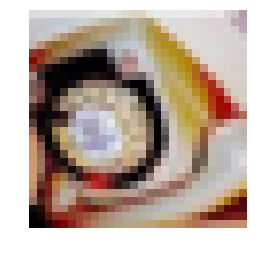

[  5.  40.]


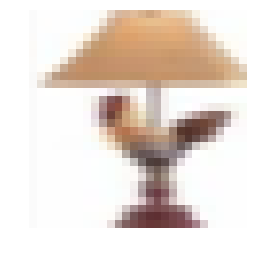

In [8]:
# Print out the label and picture of the first element of training data as a check
print(train_labels[0])
plot_image(train_data[0])

# Print out the label and picture of the first element of testing data as a check
print(test_labels[0])
plot_image(test_data[0])

# Convolutional Neural Network

## Preprocessing Data

**Distributing training set into sampling and training sets**

In [9]:
height = 28
width = 28
channels = 3

sample_percent = .1
length0 = int(len(train_data)*(sample_percent)+.5)
length1 = int(len(train_data)*(1-sample_percent))

train_data0 = np.zeros((length0, height, width, channels))
train_labels0 = np.zeros((1, length0))

train_data1 = np.zeros((length1, height, width, channels))
train_labels1 = np.zeros((1, length1))
train_labels1_f = np.zeros((length1, 100))

count = [0, 0]
for i in range(len(train_data)):
    if count[0] < length0 and count[1] < length1:
        rand_num = rnd.random()
        if rand_num >= sample_percent:
            train_data0[count[0]] = train_data[count[0]+count[1]]
            train_labels0[0, count[0]] = train_labels[count[0]+count[1], 0]
            count[0] += 1
        else:
            train_data1[count[1]] = train_data[count[0]+count[1]]
            train_labels1[0, count[0]] = train_labels[count[0]+count[1], 0]
            train_labels1_f[count[0], int(train_labels[count[0]+count[1], 1])] += 1
            count[1] += 1
    elif count[0] < length0:
        train_data0[count[0]] = train_data[count[0]+count[1]]
        count[0] += 1
    elif count[1] < length1:
        train_data1[count[1]] = train_data[count[0]+count[1]]
        train_labels1[0, count[0]] = train_labels[count[0]+count[1], 0]
        train_labels1_f[count[0], int(train_labels[count[0]+count[1], 1])] += 1
        count[1] += 1

In [38]:
height = 28
width = 28
channels = 3
length = len(test_labels)

test_data_adj   = np.zeros((length, height, width, channels))
test_labels_adj = np.zeros((length, 100))

for i in range(length):
    test_labels_adj[i] = test_labels[i, 1]
    for j in range(height):
        for k in range(width):
            for l in range(channels):
                test_data_adj[i][j][k][l] = test_data[i, j, k, l]

In [44]:
# Defining parameters for filter array
num_supercategories = 2
num_subcategories = 100

distrib = np.zeros((num_supercategories, num_subcategories))

# Create filter array by adding 1 at the index and subcategory provided
for i in range(len(train_labels0[0])):
    if train_labels[i, 0] == 5:
        distrib[0, int(train_labels0[0, i])] += 1
    elif train_labels[i, 0] == 6:
        distrib[1, int(train_labels0[0, i])] += 1

# Normalizing Vector Prior to network
for i in range(len(distrib[0])):
    total = distrib[0, i] + distrib[1, i]
    if total>0:
        distrib[0] = distrib[0]/(total)
        distrib[1] = distrib[1]/(total)

weights = np.zeros((num_supercategories, len(train_labels1[0]), num_subcategories))
test_weights = np.zeros((num_supercategories, len(test_labels_adj), num_subcategories))
# LIKELY BETTER WAY TO DO THIS
for i in range(len(train_labels1[0])):
    weights[0, i] = distrib[0]
    weights[1, i] = distrib[1]
for i in range(len(test_labels_adj)):
    test_weights[0, i] = distrib[0]
    test_weights[1, i] = distrib[1]

## Defining Structure

In [11]:
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Dropout, multiply, add, merge, dot, Flatten, Reshape, Activation
from keras.layers.merge import Multiply, Maximum
from keras.backend import constant, placeholder, expand_dims
from keras.models import Model

coarse_categories = 20
fine_categories = 100

input_img = Input(shape=(28, 28, 3), dtype='float32', name='main_input')


## SHARED LAYERS
conv_shared = Conv2D(12, (4, 4), strides=(1, 1), padding='same', activation='relu')(input_img)
pool_shared = MaxPooling2D((2, 2), padding='same')(conv_shared)
shared_output = Dropout(0.25)(pool_shared)


## FOR COARSE CLASSIFIER
conv1_c = Conv2D(6, 2, strides=1, activation='relu', padding='same')(shared_output)
pool1_c = MaxPooling2D(pool_size=2, strides=2, padding='same')(conv1_c)
conv2_c = Conv2D(3, 2, strides=1, activation='relu', padding='same')(pool1_c)
conv2_c = Conv2D(3, 2, strides=1, activation='relu', padding='same')(conv2_c)
conv2_c = Conv2D(3, 2, strides=1, activation='relu', padding='same')(conv2_c)
conv2_c = Reshape([-1])(conv2_c)

dense_c = Dense(256, activation='relu')(conv2_c)
dense_c = Dropout(0.50)(dense_c)
dense_c = Dense(128, activation='relu')(dense_c)
dense_c = Dropout(0.25)(dense_c)
output_c = Dense(num_subcategories, activation='softmax')(dense_c)


weights_a = Input(shape=[100], dtype='float32', name='weights_a') #tensor=constant(distrib[0]))
weights_b = Input(shape=[100], dtype='float32', name='weights_b')
#weights_a_s = Reshape([-1])(weights_a)
#weights_b_s = Reshape([-1])(weights_b)

#weights1 = Input(tensor=constant(distrib[1]))
#weights0 = constant(distrib[0])
#weights0 = Reshape(target_shape=(None, -1))(weights0)
#weights0 = Input(shape=([100]), dtype='float32', name='weight0')
output_weights_a = multiply([output_c,weights_a])

#weights1 = Input(shape=([100]), dtype='float32', name='weight1')
output_weights_b = multiply([output_c,weights_b])

pre_output = output_c;


## FOR FINE CLASSIFIER 1:
conv1_f = Conv2D(6, 2, strides=1, activation='relu', padding='same')(shared_output)
pool1_f = MaxPooling2D(pool_size=2, strides=2, padding='same')(conv1_f)
drop2_f = Dropout(0.25)(pool1_f)
conv2_f = Conv2D(3, 2, strides=1, activation='relu', padding='same')(drop2_f)
conv2_f = Conv2D(3, 2, strides=1, activation='relu', padding='same')(conv2_f)
conv2_f = Conv2D(3, 2, strides=1, activation='relu', padding='same')(conv2_f)
conv2_f = Reshape([-1])(conv2_f)

dense_f = Dense(256, activation='relu')(conv2_f)
dense_f = Dropout(0.50)(dense_f)
dense_f = Dense(128, activation='relu')(dense_f)
dense_f = Dropout(0.25)(dense_f)
dense_f = Dense(100, activation='softmax')(dense_f)

pre_output = multiply([dense_f, output_weights_a])

## FOR FINE CLASSIFIER 2:
conv1_f = Conv2D(6, 2, strides=1, activation='relu', padding='same')(shared_output)
pool1_f = MaxPooling2D(pool_size=2, strides=2, padding='same')(conv1_f)
drop2_f = Dropout(0.25)(pool1_f)
conv2_f = Conv2D(3, 2, strides=1, activation='relu', padding='same')(drop2_f)
conv2_f = Conv2D(3, 2, strides=1, activation='relu', padding='same')(conv2_f)
conv2_f = Conv2D(3, 2, strides=1, activation='relu', padding='same')(conv2_f)
conv2_f = Reshape([-1])(conv2_f)

dense_f = Dense(256, activation='relu')(conv2_f)
dense_f = Dropout(0.50)(dense_f)
dense_f = Dense(128, activation='relu')(dense_f)
dense_f = Dropout(0.25)(dense_f)
dense_f = Dense(100, activation='softmax')(dense_f)

tmp = multiply([dense_f, output_weights_b])
pre_output = add([tmp, pre_output])

output = Activation('softmax')(pre_output)


model = Model(inputs=[input_img, weights_a, weights_b], outputs=output)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
model.fit([train_data1, weights[0], weights[1]], train_labels1_f, epochs=5, batch_size=64)

Epoch 1/5
4500/4500 [==============================] - 5s - loss: 4.6052 - acc: 0.0011           - ETA: 13s - loss: 0.0411 - acc: 0.0000e+00

In [24]:
index = 45
model.save_weights('data/models/layer_'+str(index))
model.load_weights('data/models/layer_'+str(index), by_name=False)
model.fit([train_data1, weights[0], weights[1]], train_labels1_f, epochs=i+5, batch_size=64, initial_epoch=index)

Epoch 46/50
4500/4500 [==============================] - 4s - loss: 4.6052 - acc: 0.9796     

In [45]:
model.evaluate([test_data_adj, test_weights[0], test_weights[1]], test_labels_adj, batch_size=64, verbose=1)

 960/1000 [===========================>..] - ETA: 0s

[23117.954390625, 0.998]